Github Issue: https://github.com/dmwm/CRABServer/issues/7312

This Notebook show plots and queries of the following tasks:
- Task1 - Sum of "WallClockHr" by "CMSPrimaryDataTier
- Task2 - Sum of "WallClockHr" by "Type" ['production', 'analysis']
- Task3 - Sum of "WallClockHr" filter "Type"['analysis'] by "CRAB_DataBlock" ['MCFakeBlock', Else] (MC Prod vs Analysis)
- Task4 - Average CPU Efficiency group by "RecordTime" each hour and "InputData" ['onsite', 'offsite']
- Task5 - Success rate of the "Type" ['analysis']

Note: The raw data is filtered to drop_duplicates(["GlobalJobId"]) and Status IN ('Completed', 'Removed', 'Held', 'Error') of the date May 1st

In [1]:
import time
from datetime import datetime, date, timedelta

import click
import numpy as np
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    lit,
    when,
    sum as _sum,
    first,
)
from pyspark.sql.types import (
    StructType,
    LongType,
    StringType,
    StructField,
    DoubleType,
    IntegerType,
)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"

In [3]:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("CMSSite", StringType(), nullable=True),
                        StructField("RecordTime", LongType(), nullable=False),
                        StructField("InputData", StringType(), nullable=True),
                        StructField("Chirp_CRAB3_Job_ExitCode", LongType(), nullable=True),
                        StructField("CMSPrimaryDataTier", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True),
                        StructField("OverflowType", StringType(), nullable=True),
                        StructField("WallClockHr", DoubleType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("Type", StringType(), nullable=True),
                        StructField("CRAB_DataBlock", StringType(), nullable=True),
                        StructField("GlobalJobId", StringType(), nullable=False),
                    ]
                ),
            ),
        ]
    )
def get_candidate_files(
    start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER,
):
    """
    Returns a list of hdfs folders that can contain data for the given dates.
    """
    st_date = start_date - timedelta(days=3)
    ed_date = end_date + timedelta(days=3)
    days = (ed_date - st_date).days
    #what is pre_candidate_files for????
    pre_candidate_files = [
        "{base}/{day}{{,.tmp}}".format(
            base=base, day=(st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    sc = spark.sparkContext
    # The candidate files are the folders to the specific dates,
    # but if we are looking at recent days the compaction procedure could
    # have not run yet so we will considerate also the .tmp folders.
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
        for i in range(0, days)
    ]
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    return candidate_files


In [4]:
schema = _get_schema()
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 5, 2)

In [5]:
get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER)

['/project/monitoring/archive/condor/raw/metric/2022/04/28',
 '/project/monitoring/archive/condor/raw/metric/2022/04/29',
 '/project/monitoring/archive/condor/raw/metric/2022/04/30',
 '/project/monitoring/archive/condor/raw/metric/2022/05/01',
 '/project/monitoring/archive/condor/raw/metric/2022/05/02',
 '/project/monitoring/archive/condor/raw/metric/2022/05/03',
 '/project/monitoring/archive/condor/raw/metric/2022/05/04']

In [6]:
raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        ).select("data.*")
        .filter(
            f"""Status IN ('Completed', 'Removed', 'Held', 'Error') 
          AND RecordTime >= {start_date.timestamp() * 1000}
          AND RecordTime < {end_date.timestamp() * 1000}
          """
        )
        .drop_duplicates(["GlobalJobId"])
    )

spark.conf.set("spark.sql.session.timeZone", "UTC")

In [7]:
raw_df.printSchema()

root
 |-- CMSSite: string (nullable = true)
 |-- RecordTime: long (nullable = true)
 |-- InputData: string (nullable = true)
 |-- Chirp_CRAB3_Job_ExitCode: long (nullable = true)
 |-- CMSPrimaryDataTier: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- OverflowType: string (nullable = true)
 |-- WallClockHr: double (nullable = true)
 |-- CpuTimeHr: double (nullable = true)
 |-- RequestCpus: long (nullable = true)
 |-- Type: string (nullable = true)
 |-- CRAB_DataBlock: string (nullable = true)
 |-- GlobalJobId: string (nullable = true)



# TASK 1

### Sum of "WallClockHr" by "CMSPrimaryDataTier"

In [11]:
df1 = raw_df.groupby([col("CMSPrimaryDataTier")])\
            .agg(_sum("WallClockHr").alias("Sum_WallClockHr"))\
            .sort("Sum_WallClockHr")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# df1.show(10)


In [12]:
df1 = df1.toPandas()

In [13]:
sumWallClockHr = df1.Sum_WallClockHr.values.tolist()
dataTier = df1.CMSPrimaryDataTier.values.tolist()

sumWc = sum(sumWallClockHr)
data = []
legends = []
others = 0
otherTiers = []

for i in range(len(sumWallClockHr)):
    percent = sumWallClockHr[i]*100/sumWc
    if(percent<1):
        others+=percent
        otherTiers.append(dataTier[i]+": %.3f"%percent+"%")
    else:
        data.append(percent)
        legends.append(dataTier[i])
data.append(others)
legends.append("Others")

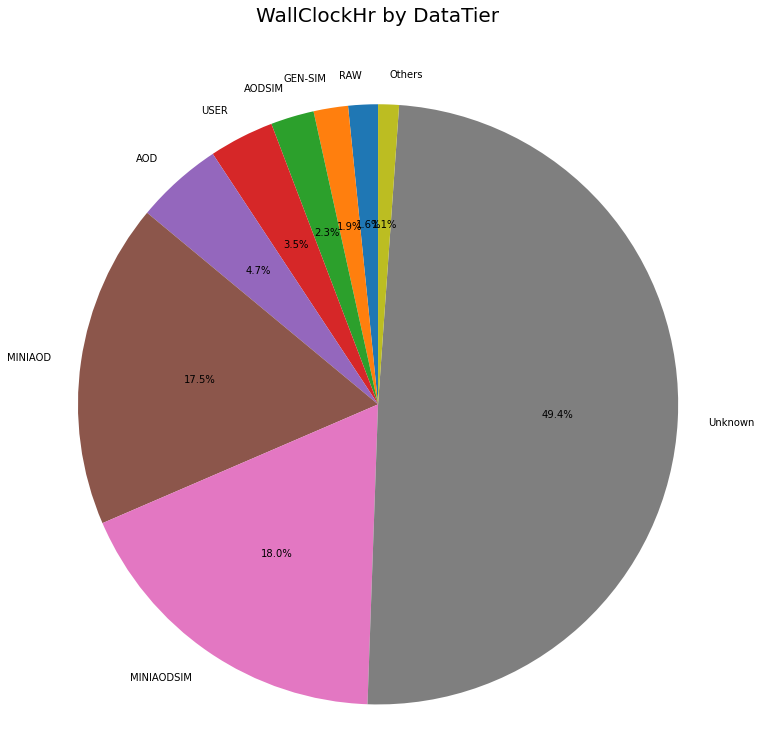

GEN-SIM-DIGI-RAW-HLTDEBUG: 0.001%
RECO: 0.015%
GEN-SIM-DIGI-RAW-MINIAOD: 0.039%
GEN-SIM-RECO: 0.044%
LHE: 0.057%
NANOAODSIM: 0.060%
RAW-RECO: 0.068%
GEN-SIM-RAW: 0.093%
FEVT: 0.112%
ALCARECO: 0.199%
GEN-SIM-DIGI-RAW: 0.431%


In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams["figure.figsize"] = (12,12)
fig1, ax1 = plt.subplots()
figure_title = 'WallClockHr by DataTier'
plt.title(figure_title, y=1.08, fontsize=20)
ax1.pie(data, labels=legends, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal') 
# plt.savefig('final-wc-datatier.png')
plt.show()
print(*otherTiers, sep = "\n")

# TASK 2

### Sum of "WallClockHr" by "Type" ['production', 'analysis']

In [62]:
df2 = raw_df.filter(col('Type').isin(['production', 'analysis']))\
            .groupby([col('Type')])\
            .agg(_sum("WallClockHr").alias("Sum_WallClockHr"))


In [63]:
df2 = df2.toPandas()

In [64]:
df2

,Type,Sum_WallClockHr
0,production,1730748.252
1,analysis,2642540.557


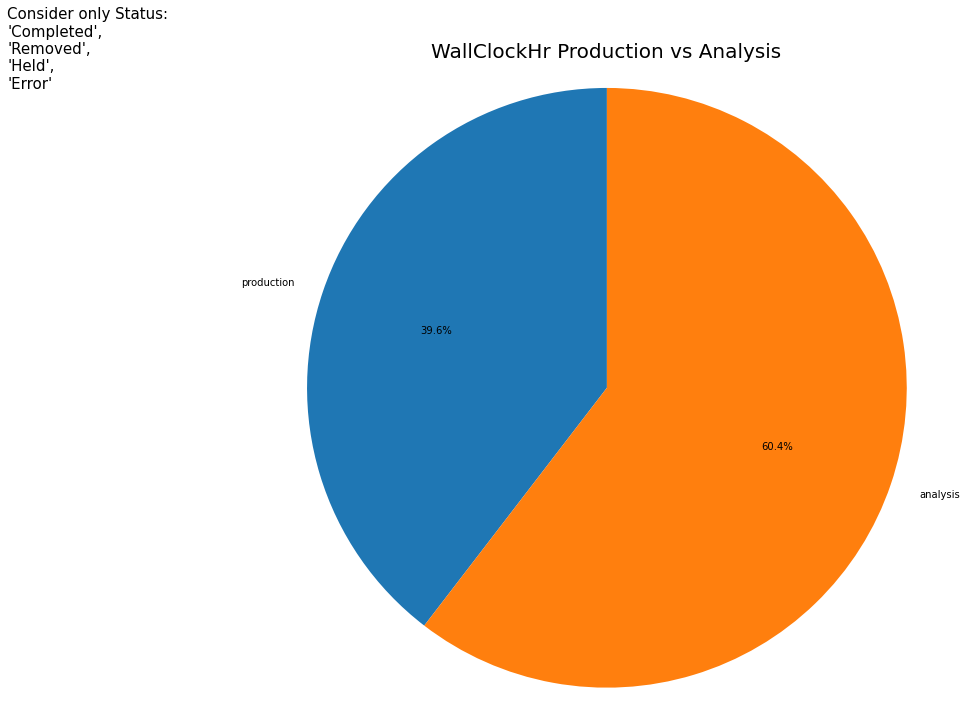

In [75]:
sumWallClockHr2 = df2.Sum_WallClockHr.values.tolist()
dataType = df2.Type.values.tolist()
plt.rcParams["figure.figsize"] = (12,12)
fig2, ax2 = plt.subplots()
figure_title = 'WallClockHr Production vs Analysis'
plt.title(figure_title, y=1, fontsize=20)
ax2.pie(sumWallClockHr2, labels=dataType, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal') 

ax2.text(-2, 1,   "Consider only Status:\n'Completed',\n'Removed',\n'Held',\n'Error'", fontsize=15)
# plt.savefig('final-wc-prod-analysis.png')
plt.show()

# TASK 3

### Sum of "WallClockHr" filter "Type"['analysis'] by "CRAB_DataBlock" ['MCFakeBlock', Else]

In [63]:
#sum wallclock analysis vs mc production -> mc is analysis w/o input data 
df3 = raw_df.filter(col('Type')=='analysis')\
            .withColumn('isMcprod', when(col('CRAB_DataBlock')=='MCFakeBlock', 'mc').otherwise('notMc'))\
            .groupby([col('isMcprod')])\
            .agg(_sum("WallClockHr").alias("Sum_WallClockHr"))


In [64]:
df3.show()

+--------+------------------+
|isMcprod|   Sum_WallClockHr|
+--------+------------------+
|   notMc|2250814.3538888884|
|      mc|391733.17500000005|
+--------+------------------+



In [65]:
df3 = df3.toPandas()

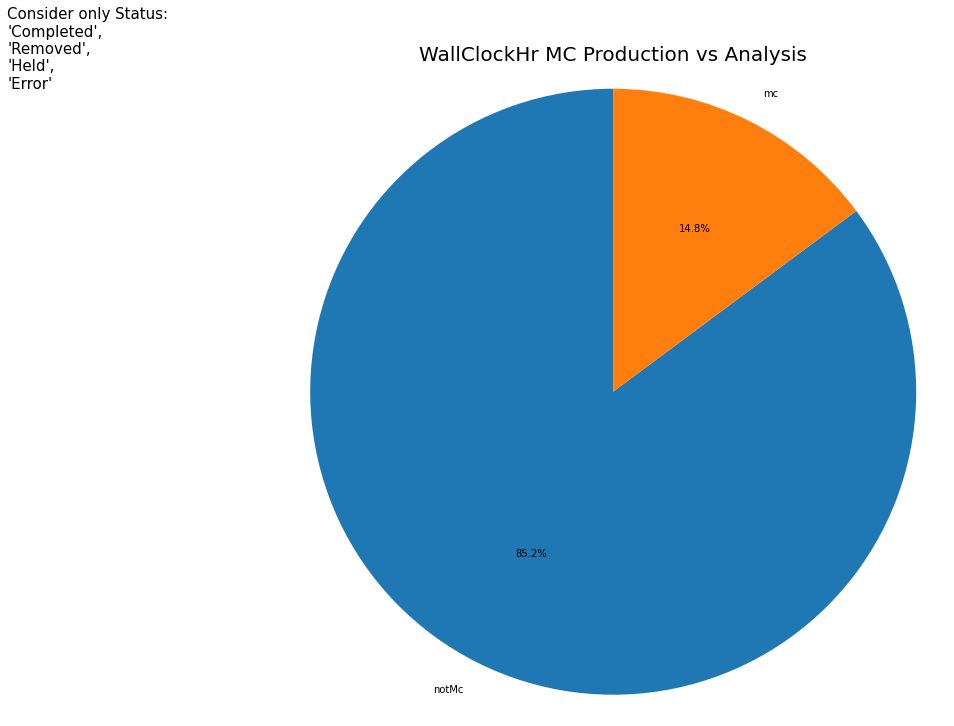

In [67]:
sumWallClockHr3 = df3.Sum_WallClockHr.values.tolist()
isMcProd = df3.isMcprod.values.tolist()
plt.rcParams["figure.figsize"] = (12,12)
fig2, ax2 = plt.subplots()
figure_title = 'WallClockHr MC Production vs Analysis'
plt.title(figure_title, y=1, fontsize=20)
ax2.pie(sumWallClockHr3, labels=isMcProd, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal') 

ax2.text(-2, 1,   "Consider only Status:\n'Completed',\n'Removed',\n'Held',\n'Error'", fontsize=15)
plt.savefig('final-wc-mc-prod-analysis.png')
plt.show()

# TASK 4

### Average CPU Efficiency group by "RecordTime" each hour and "InputData" ['onsite', 'offsite']

Note: Average CPU Efficiency = SUM(CpuTimeHr)/SUM(WallClockHr * RequestCpus)

In [91]:
from pyspark.sql.functions import from_unixtime, when, col
from pyspark.sql.types import *
from pyspark.sql.functions import date_format
import pandas as pd

In [78]:
raw_df.select(col("RecordTime")).limit(20).show()

+-------------+
|   RecordTime|
+-------------+
|1651386242000|
|1651386242000|
|1651412162000|
|1651412162000|
|1651412162000|
|1651411922000|
|1651415761000|
|1651415761000|
|1651415761000|
|1651412162000|
|1651384801000|
|1651384801000|
|1651384801000|
|1651422991000|
|1651398481000|
|1651400642000|
|1651372510000|
|1651372551000|
|1651402081000|
|1651366081000|
+-------------+



In [20]:
#avg cpu eff → read mode (onsite vs offsite)
raw_df.createOrReplaceTempView("day")
df4 = spark.sql('SELECT     DATE_FORMAT(FROM_UNIXTIME(day.RecordTime/1000), "HH") AS timestamp,\
                            day.InputData AS inputData, \
                            SUM(day.CpuTimeHr) AS sumWallclockHr, \
                            SUM(day.WallClockHr*day.RequestCpus) as sumCoreHr, \
                            SUM(day.CpuTimeHr)/SUM(day.WallClockHr*day.RequestCpus) AS avgCpuEff \
                    FROM day \
                    GROUP BY DATE_FORMAT(FROM_UNIXTIME(day.RecordTime/1000), "HH"), inputData\
                    ORDER BY DATE_FORMAT(FROM_UNIXTIME(day.RecordTime/1000), "HH")')




In [21]:
df4.show()

+---------+---------+------------------+------------------+------------------+
|timestamp|inputData|    sumWallclockHr|         sumCoreHr|         avgCpuEff|
+---------+---------+------------------+------------------+------------------+
|       00|   Onsite|215188.11749999985| 377737.8124999998|0.5696758714088226|
|       00|  Offsite|12040.660000000003|15678.095833333335|0.7679924990890955|
|       01|   Onsite|253714.67361111107| 421213.1602777775|0.6023427032616783|
|       01|  Offsite|18165.788055555557|17987.823888888877|1.0098935906736672|
|       02|  Offsite|13906.716944444446|17003.585833333334|0.8178696588329106|
|       02|   Onsite|220685.21472222218|376399.76694444485|0.5863053968224015|
|       03|   Onsite|213668.96055555556| 376594.6827777778|0.5673711561180964|
|       03|  Offsite| 10736.61916666667| 14042.77055555555|0.7645655908277365|
|       04|  Offsite| 9406.169444444451|12472.360833333336|0.7541611063164357|
|       04|   Onsite|264012.89972222236|447657.89555

In [22]:
df4Onsite = df4.filter(col('inputData')=='Onsite').toPandas()
df4Offsite = df4.filter(col('inputData')=='Offsite').toPandas()

In [23]:
df4Offsite

,timestamp,inputData,sumWallclockHr,sumCoreHr,avgCpuEff
0,00,Offsite,12040.660000,15678.095833,0.767992
1,01,Offsite,18165.788056,17987.823889,1.009894
2,02,Offsite,13906.716944,17003.585833,0.817870
3,03,Offsite,10736.619167,14042.770556,0.764566
4,04,Offsite,9406.169444,12472.360833,0.754161
5,05,Offsite,10587.841944,16818.524444,0.629535
6,06,Offsite,7935.978889,10366.371389,0.765550
7,07,Offsite,10861.010278,11775.517222,0.922338
8,08,Offsite,13863.847500,12643.568056,1.096514
9,09,Offsite,14933.836667,11382.516389,1.311998


In [24]:
df4OnsiteAvg = df4Onsite.avgCpuEff.values.tolist()
df4OffsiteAvg = df4Offsite.avgCpuEff.values.tolist()

In [25]:
from statistics import mean
meanOffsite=mean(df4OffsiteAvg)
meanOnsite=mean(df4OnsiteAvg)
meanOffsiteList = []
meanOnsiteList = []
for i in range(24):
    meanOffsiteList.append(meanOffsite)
    meanOnsiteList.append(meanOnsite)

In [27]:
meanOnsite

0.6014924517487457

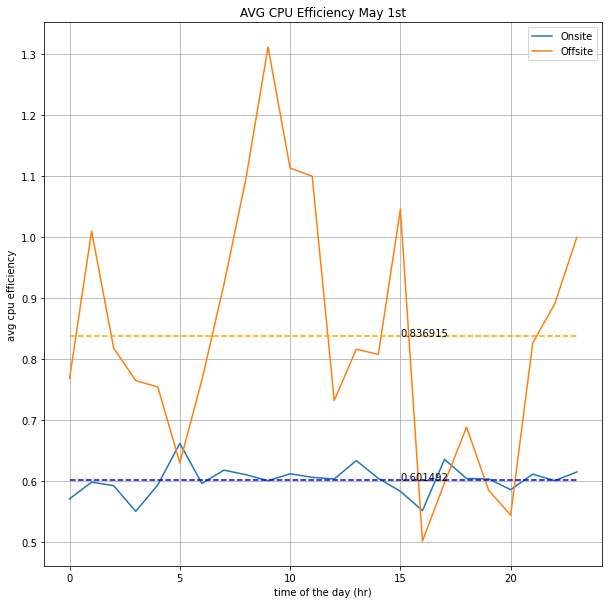

In [53]:
# Data for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
hour = np.arange(0, 24, 1)


fig, ax = plt.subplots()
ax.plot(hour, df4OnsiteAvg, label='Onsite')
ax.plot(hour, df4OffsiteAvg, label='Offsite')

ax.plot(hour, meanOnsiteList, color="blue", linestyle="--")
ax.plot(hour, meanOffsiteList, color="orange", linestyle="--")

ax.text(15,meanOnsite,'%f' % (meanOnsite))
ax.text(15,meanOffsite,'%f' % (meanOffsite))



ax.set(xlabel='time of the day (hr)', ylabel='avg cpu efficiency',
       title='AVG CPU Efficiency May 1st')
ax.grid()
plt.legend()

# plt.savefig('final-avg-cpueff-onsite-offsite.png')
plt.show()

# TASK 5

### Success rate of the "Type" ['analysis']

The success rate is converted from the "Chirp_CRAB3_Job_ExitCode" where 0 == 'Success', Else = 'Fail'

In [16]:
#check conversion of exitCode -> 1 vs 0 -> ignore null
# 0 == success, else == fail
# exitCodeZero = raw_df.filter((col("Chirp_CRAB3_Job_ExitCode")==0)&(col("Type")=="analysis")).count()

In [17]:
# exitCodeZero

In [18]:
# exitCodeOne = raw_df.filter((col("Chirp_CRAB3_Job_ExitCode")!=0) & (col("Chirp_CRAB3_Job_ExitCode").isNotNull()))\
#                     .count()
# exitCodeOne

In [19]:
# newExitCode = raw_df.withColumn('exitCode', when((col("Chirp_CRAB3_Job_ExitCode")!=0) & (col("Chirp_CRAB3_Job_ExitCode").isNotNull()), 1).otherwise(col("Chirp_CRAB3_Job_ExitCode")))\
#             .select('exitCode')
# newZero = newExitCode.filter(col('exitCode')==0).count()
# newOne = newExitCode.filter(col('exitCode')==1).count()

In [20]:
# print(newZero)
# print(newOne)

In [59]:
#analysis success rate
from pyspark.sql.functions import count as _count
df5 = raw_df.withColumn('exitCode', when((col("Chirp_CRAB3_Job_ExitCode")!=0) & (col("Chirp_CRAB3_Job_ExitCode").isNotNull()), 1).otherwise(col("Chirp_CRAB3_Job_ExitCode")))\
                    .select('exitCode', col('Type'))\
                    .filter(col("Type")=="analysis")\
                    .groupby('exitCode')\
                    .agg(_count(when(col('exitCode')==1, True)).alias('countFail'), _count(when(col('exitCode')==0, True)).alias('countSuccess'))




In [60]:
df5.show()

+--------+---------+------------+
|exitCode|countFail|countSuccess|
+--------+---------+------------+
|       0|        0|      166782|
|    null|        0|           0|
|       1|   154587|           0|
+--------+---------+------------+



In [61]:
countFail = df5.collect()[2][1]
countSuccess = df5.collect()[0][2]

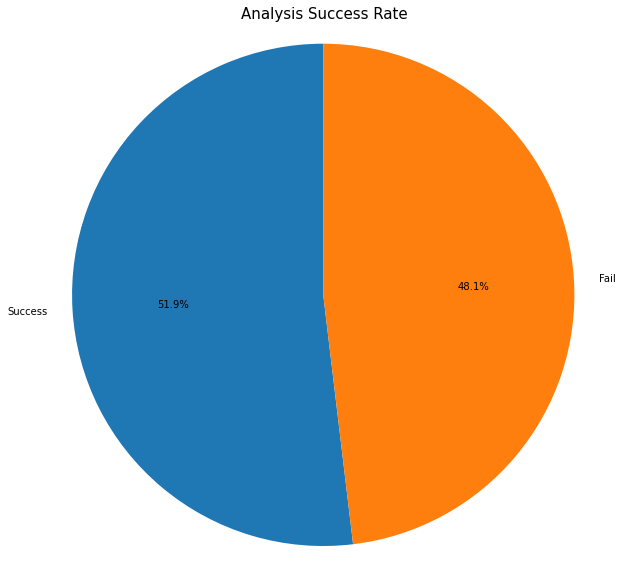

In [68]:
plt.rcParams["figure.figsize"] = (10,10)
fig2, ax2 = plt.subplots()
figure_title = 'Analysis Success Rate'
plt.title(figure_title, y=1, fontsize=15)
ax2.pie([countSuccess, countFail], labels=["Success", "Fail"], autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2.axis('equal') 


# plt.savefig('final-analysis-success-rate.png')
plt.show()